In [1]:
import petri_net_toolkit as pntk
from petri_net_toolkit.nets import TestNet
import numpy as np
import torch
from torch.nn import functional as F
from torch.distributions import Categorical
import matplotlib.pyplot as plt
import collections
import random
from tqdm import tqdm

In [2]:
env = TestNet('test_net')
env.draw_net()

/Users/jason/Documents/SJTU_pro/Projects/DTG/PetriNets/petri_net_toolkit/petri_nets.py:26: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.pt_matrix.loc[element.name] = np.zeros(len(self.pt_matrix.columns))


In [3]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)

    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        transitions = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*transitions)
        return np.array(state), action, reward, np.array(next_state), done

    def size(self):
        return len(self.buffer)

In [4]:
class Qnet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(Qnet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x), dim=-1)
        return x

In [5]:
class DQN():
    def __init__(self, state_dim, hidden_dim, action_dim, learning_rate, gamma, epsilon, target_update):
        self.state_dim = state_dim
        self.hidden_dim = hidden_dim
        self.action_dim = action_dim
        self.q_net = Qnet(self.state_dim, self.hidden_dim, self.action_dim)
        self.target_q_net = Qnet(self.state_dim, self.hidden_dim, self.action_dim)
        self.optimizer = torch.optim.Adam(self.q_net.parameters(), lr=learning_rate)
        self.gamma = gamma
        self.epsilon = epsilon
        self.target_update = target_update
        self.count = 0
        
    def take_action(self, state):           # epsilon-greedy
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.action_dim)
        else:
            state = torch.tensor([state], dtype=torch.float).flatten()
            action = self.q_net(state).argmax().item()
        return action
    
    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'], dtype=torch.float)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1)
        rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1, 1)
        next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float)
        dones = torch.tensor(transition_dict['dones'], dtype=torch.float).view(-1, 1)
        q_values = self.q_net(states).gather(1, actions)        # use actions to index Q value
        max_next_q_values = self.target_q_net(next_states).max(1)[0].view(-1, 1)
        q_targets = rewards + self.gamma * max_next_q_values * (1 - dones)
        dqn_loss = torch.mean(F.mse_loss(q_values, q_targets))
        self.optimizer.zero_grad()
        dqn_loss.backward()
        self.optimizer.step()

        if self.count % self.target_update == 0:
            self.target_q_net.load_state_dict(self.q_net.state_dict())
        self.count += 1
        

In [6]:
state_dim, _ = env.observation_space
hidden_dim = 128
action_dim = env.action_space
lr = 2e-3
gamma = 0.98
epsilon = 0.5
target_update = 50

num_episodes = 500
buffer_size = 10000
minimal_size = 500
batch_size = 64
replay_buffer = ReplayBuffer(buffer_size)

In [7]:
agent = DQN(state_dim=state_dim, hidden_dim=hidden_dim, action_dim=action_dim, learning_rate=lr, gamma=gamma, epsilon=epsilon, target_update=target_update)

return_list = []
output_traj = []
output_time = []
for i in range(10):
    with tqdm(total=int(num_episodes/10), desc='Iteration %d' % i) as pbar:
        for i_episode in range(int(num_episodes/10)):
            episode_return = 0
            state = env.reset()
            done = False
            max_T = 200
            T = 0
            traj_8 = []
            finish_flag = False
            while (not done) and (T < max_T):
                action = agent.take_action(state)
                next_state, reward, done = env.step(action)
                replay_buffer.add(state, action, reward, next_state, done)
                state = next_state
                episode_return += reward
                if replay_buffer.size() > minimal_size:
                    b_s, b_a, b_r, b_ns, b_d = replay_buffer.sample(batch_size)
                    transition_dict = {'states': b_s, 'actions': b_a, 'next_states': b_ns, 'rewards': b_r, 'dones': b_d}
                    agent.update(transition_dict)
                T += 1
                traj_8.append(env.places['p8'].token['default'])
                if env.places['p8'].token['default'] >=10 and (finish_flag == False):
                    output_time.append(env.act_time)
                    finish_flag = True
                    break
            if not finish_flag:
                output_time.append(env.act_time)
            output_traj.append(traj_8)
            return_list.append(episode_return)
            if (i_episode+1) % 10 == 0:
                pbar.set_postfix({'episode': '%d' % (num_episodes/10 * i + i_episode+1), 'return': '%.3f' % np.mean(return_list[-10:])})
            pbar.update(1)

Iteration 0:   0%|          | 0/50 [00:00<?, ?it/s]/var/folders/7x/vkxy_bn547d757f8znyxd6rh0000gn/T/ipykernel_41990/3029230075.py:18: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  state = torch.tensor([state], dtype=torch.float).flatten()
Iteration 9: 100%|██████████| 50/50 [00:01<00:00, 44.59it/s, episode=500, return=1932.800]


In [8]:
print(return_list)

[1849.999995898304, 1871.999995898304, 1711.99999598075, 1787.9999959189154, 1885.9999959395273, 1787.9999960013615, 1807.9999959395268, 1835.9999959601387, 1711.999996021973, 1927.9999959189156, 1909.999995898304, 1769.9999959807496, 1903.9999959395268, 1829.999996021973, 1707.999996042584, 1709.9999960631958, 1913.9999959395273, 1829.9999959395268, 1801.9999959807496, 1919.9999959601387, 1787.9999959395268, 1919.999995898304, 1857.9999959189154, 1869.9999960013615, 1731.9999959807496, 1901.9999959601382, 1885.9999959395273, 1851.9999959601382, 1751.9999960631962, 1813.999996001361, 1725.9999959807496, 1747.9999960425848, 1841.9999959601382, 1783.9999960425848, 1749.99999598075, 1825.999996021973, 1855.99999598075, 1861.999996021973, 1891.9999959395273, 1881.9999959189154, 1915.9999959189154, 1797.9999959601382, 1897.9999959395268, 1729.9999960425844, 1823.9999959807496, 1703.9999960013615, 1683.9999960425844, 1887.99999598075, 1737.9999959807496, 1781.9999959807496, 1731.999996021972

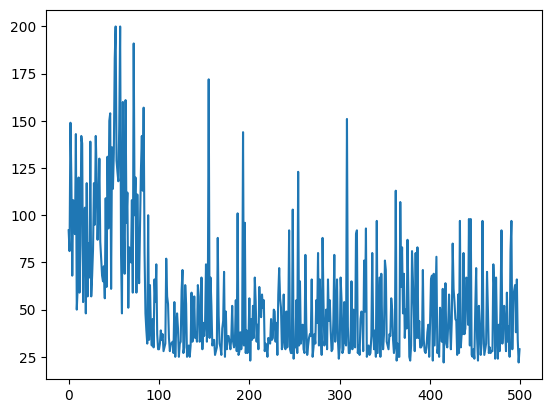

In [9]:
lens = []
for traj in output_traj:
    lens.append(len(traj))
plt.plot(range(len(lens)), lens)

Text(0, 0.5, 'output num')

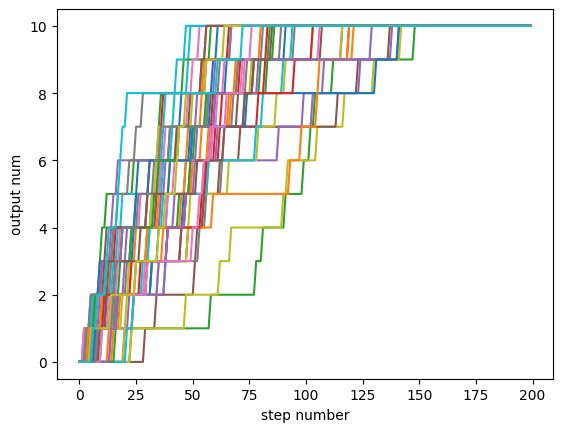

In [10]:
# ======= plot output traj =======
max_traj = max(len(traj) for traj in output_traj)
step_num = range(max_traj)
for traj in output_traj:
    traj.extend([traj[-1]] * (max_traj - len(traj)))
    
max_step = 200
for i in range(40):
    plt.plot(step_num[:max_step], output_traj[i][:max_step])
plt.xlabel('step number')
plt.ylabel('output num')

500


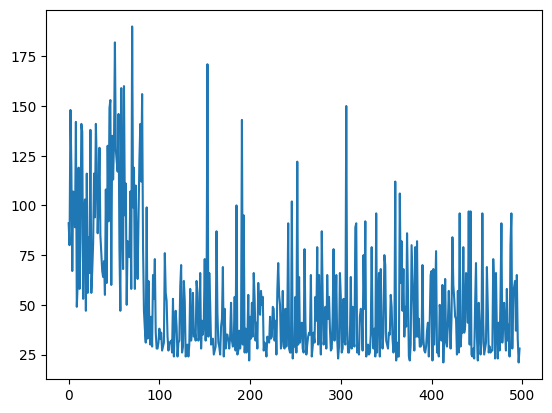

In [11]:
# ======= plot min finish step =======

min_steps = []
print(len(output_traj))
for traj in output_traj:
    for i in range(len(traj)):
        if traj[i] >= 10:
            min_steps.append(i)
            break

plt.plot(range(len(min_steps)), min_steps)

In [12]:
# ======= plot min output time =======
print(len(output_time))


500


In [13]:
for q in replay_buffer.buffer:
    print(q)

(array([0, 0, 0, 0, 1, 0, 0, 9]), 3, -2, array([0, 0, 0, 0, 1, 0, 0, 9]), False)
(array([0, 0, 0, 0, 1, 0, 0, 9]), 1, -2, array([0, 0, 0, 0, 1, 0, 0, 9]), False)
(array([0, 0, 0, 0, 1, 0, 0, 9]), 1, -2, array([0, 0, 0, 0, 1, 0, 0, 9]), False)
(array([0, 0, 0, 0, 1, 0, 0, 9]), 3, -2, array([0, 0, 0, 0, 1, 0, 0, 9]), False)
(array([0, 0, 0, 0, 1, 0, 0, 9]), 3, -2, array([0, 0, 0, 0, 1, 0, 0, 9]), False)
(array([0, 0, 0, 0, 1, 0, 0, 9]), 3, -2, array([0, 0, 0, 0, 1, 0, 0, 9]), False)
(array([0, 0, 0, 0, 1, 0, 0, 9]), 3, -2, array([0, 0, 0, 0, 1, 0, 0, 9]), False)
(array([0, 0, 0, 0, 1, 0, 0, 9]), 4, -2, array([0, 0, 0, 0, 1, 0, 0, 9]), False)
(array([0, 0, 0, 0, 1, 0, 0, 9]), 0, -2, array([0, 0, 0, 0, 1, 0, 0, 9]), False)
(array([0, 0, 0, 0, 1, 0, 0, 9]), 3, -2, array([0, 0, 0, 0, 1, 0, 0, 9]), False)
(array([0, 0, 0, 0, 1, 0, 0, 9]), 1, -2, array([0, 0, 0, 0, 1, 0, 0, 9]), False)
(array([0, 0, 0, 0, 1, 0, 0, 9]), 6, -2, array([0, 0, 0, 0, 1, 0, 0, 9]), False)
(array([0, 0, 0, 0, 1, 0, 0,